In [59]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
usecols = [
    "Make",
    "Model",
    "Year",
    "Engine HP",
    "Engine Cylinders",
    "Transmission Type",
    "Vehicle Style",
    "highway MPG",
    "city mpg",
    "MSRP",
]

df = pd.read_csv('/kaggle/input/car-price/data.csv', usecols=usecols)

df.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [61]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
col_list = list(df.dtypes[df.dtypes == 'object'].index)
    
for col in col_list:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.fillna(0, inplace = True)

df.rename(columns = {"msrp": "price"}, inplace = True)

In [62]:
df.transmission_type.value_counts()

transmission_type
automatic           8266
manual              2935
automated_manual     626
direct_drive          68
unknown               19
Name: count, dtype: int64

In [63]:
corr = df.select_dtypes("number").drop(columns = "price").corr()
corr

,year,engine_hp,engine_cylinders,highway_mpg,city_mpg
year,1.000000,0.338714,-0.040708,0.258240,0.198171
engine_hp,0.338714,1.000000,0.774851,-0.415707,-0.424918
engine_cylinders,-0.040708,0.774851,1.000000,-0.614541,-0.587306
highway_mpg,0.258240,-0.415707,-0.614541,1.000000,0.886829
city_mpg,0.198171,-0.424918,-0.587306,0.886829,1.000000


<Axes: >

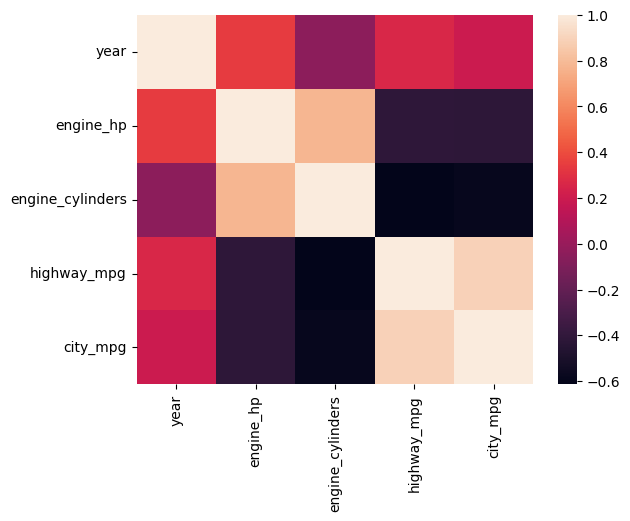

In [64]:
sns.heatmap(corr)


In [65]:
df_final = df.copy(deep=True)

In [66]:
avg_price = df_final.price.mean()
print("Average Price: ", avg_price)
df_final["above_average"] = (df_final.price > avg_price).astype(int)

del df_final["price"]

df_final.head()

Average Price:  40594.737032063116


,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,1
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,1
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,0
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,0
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,0


In [67]:
from sklearn.model_selection import train_test_split
def prepare_data_split(df, test_size, random_state, target_feature):
    df_full_train, df_test = train_test_split(df, test_size= test_size, random_state=random_state)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=random_state)
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = df_train[target_feature].values
    y_val = df_val[target_feature].values
    y_test = df_test[target_feature].values
    
    return df_train, y_train, df_val, y_val, df_test, y_test

In [68]:
test_size = 0.2
random_state = 42
target = "above_average"
df_train, y_train, df_val, y_val, df_test, y_test = prepare_data_split(df_final, test_size, random_state, target)

In [69]:
df_train, y_train

(             make     model  year  engine_hp  engine_cylinders  \
 0      mitsubishi  endeavor  2011      225.0               6.0   
 1             kia   borrego  2009      276.0               6.0   
 2     lamborghini  gallardo  2012      570.0              10.0   
 3       chevrolet  colorado  2016      200.0               4.0   
 4         pontiac      vibe  2009      158.0               4.0   
 ...           ...       ...   ...        ...               ...   
 7143       toyota    sienna  2016      266.0               6.0   
 7144    chevrolet       hhr  2009      260.0               4.0   
 7145      hyundai  veracruz  2012      260.0               6.0   
 7146   mitsubishi      expo  1993      136.0               4.0   
 7147         ford    taurus  2015      365.0               6.0   
 
      transmission_type      vehicle_style  highway_mpg  city_mpg  \
 0            automatic            4dr_suv           19        15   
 1            automatic            4dr_suv           21 

In [72]:
from sklearn.metrics import mutual_info_score

def mutual_info_churn_score(series):
    return mutual_info_score(series, df_train.above_average)

In [73]:
df_train_cat_cols = list(df_train.select_dtypes("object").columns)
print(df_train_cat_cols)

mutual_result = df_train[df_train_cat_cols].apply(mutual_info_churn_score)
mutual_result.round(2).sort_values(ascending=False)

['make', 'model', 'transmission_type', 'vehicle_style']


model                0.46
make                 0.24
vehicle_style        0.08
transmission_type    0.02
dtype: float64

In [74]:
df_train.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
above_average          int64
dtype: object

In [75]:
del df_train[target]
del df_val[target]
del df_test[target]

In [76]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

val_dict = df_test.to_dict(orient='records')
X_test = dv.transform(val_dict)

In [77]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)

model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [80]:
y_pred = model.predict_proba(X_val)[:, 1]

above_average = (y_pred >= 0.5)
model_accy = (y_val == above_average).mean()

print(model_accy.round(2))

0.95


In [82]:
def one_encode(df_train, df_val, df_test):
    dv = DictVectorizer(sparse=False)
    train_dict = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    test_dict = df_test.to_dict(orient='records')
    X_test = dv.transform(test_dict)
    return X_train, X_val, X_test

In [83]:
def train_model_accy(X_train, y_train, X_val, y_val):
    model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    
    above_average = (y_pred >= 0.5)
    model_accy = (y_val == above_average).mean()
    return model_accy


In [87]:
model_diff = []
sparse = False
cat_cols = list(df_train.select_dtypes("object").columns)
num_cols = list(df_train.select_dtypes("number").columns)
for x in range(len(cat_cols)):
    cat_cols = list(df_train.select_dtypes("object").columns)
    drop_cat = cat_cols.pop(x)
    
    X_train, X_val, X_test = one_encode(df_train[cat_cols + num_cols],
                                         df_val[cat_cols + num_cols],
                                         df_test[cat_cols + num_cols]
                                        )
    
    result = train_model_accy(X_train, y_train, X_val, y_val)
    model_diff.append([drop_cat, result - model_accy]) 
    
cat_cols = list(df_train.select_dtypes("object").columns)
num_cols = list(df_train.select_dtypes("number").columns)
for y in range(len(num_cols)):
    num_cols = list(df_train.select_dtypes("number").columns)
    
    drop_num = num_cols.pop(y)
    X_train, X_val, X_test = one_encode(df_train[cat_cols + num_cols],
                                         df_val[cat_cols + num_cols],
                                         df_test[cat_cols + num_cols]
                                       )
    
    result = train_model_accy(X_train, y_train, X_val, y_val)
    model_diff.append([drop_num, result - model_accy])  
    
final_result = pd.DataFrame(model_diff, columns = ["model_without", "difference"])
final_result["abs_diff"] = final_result["difference"].abs()
final_result.sort_values(by='abs_diff')

,model_without,difference,abs_diff
6,engine_cylinders,0.000000,0.000000
0,make,0.001259,0.001259
4,year,0.001259,0.001259
2,transmission_type,-0.001679,0.001679
7,highway_mpg,-0.002937,0.002937
3,vehicle_style,-0.010071,0.010071
8,city_mpg,-0.014687,0.014687
5,engine_hp,-0.024339,0.024339
1,model,-0.031053,0.031053


In [88]:
df

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,46135
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,40650
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,36350
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,29450
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,34500
...,...,...,...,...,...,...,...,...,...,...
11909,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,46120
11910,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,56670
11911,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,50620
11912,acura,zdx,2013,300.0,6.0,automatic,4dr_hatchback,23,16,50920


In [92]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from math import sqrt


test_size = 0.2
random_state = 42
target = "price"

categorical = [
    'make',
    'model',
    'vehicle_style',
    'transmission_type'
]

numerical = [
    'year',
    'engine_hp',
    'highway_mpg',
    'city_mpg',
    'engine_cylinders']


df_train, y_train, df_val, y_val, df_test, y_test = prepare_data_split(df, test_size, random_state, target)

y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
y_test = np.log1p(y_test)
    
del df_train[target]
del df_val[target]
del df_test[target]

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

alpha = [0, 0.01, 0.1, 1, 10]
for a in alpha:
    model = Ridge(solver='sag', random_state=42, alpha=a)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = sqrt(mean_squared_error(y_val, y_pred))

    print(f'For alpha {a} RMSE is {round(rmse, 3)}')

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


For alpha 0 RMSE is 0.487


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


For alpha 0.01 RMSE is 0.487


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


For alpha 0.1 RMSE is 0.487


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


For alpha 1 RMSE is 0.487
For alpha 10 RMSE is 0.487


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
